### 1. Import dependencies

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

from keras import Model, layers

from keras.models import load_model

# from keras import Sequential

Using TensorFlow backend.


In [3]:
keras.__version__

'2.2.2'

### 2. Create Keras data generators 

In [4]:
data_dir_train = 'data/train'
data_dir_validation = 'data/validation'

img_size = 224
batch_size = 32
epochs = 3

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    batch_size=batch_size,
    class_mode='binary',
    target_size=(img_size,img_size))

validation_generator = validation_datagen.flow_from_directory(
    data_dir_validation,
    shuffle=False,
    class_mode='binary',
    target_size=(img_size,img_size))

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### 3. Import pre-trained ResNet50 and stack trainable layers on top of it

In [6]:
# keras.backend.set_learning_phase(0) # see https://github.com/keras-team/keras/issues/9214  and https://github.com/keras-team/keras/pull/9965

conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

# freeze layers in ResNet50
for layer in conv_base.layers:
    layer.trainable = False

/home/patryk/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
x = conv_base.output
# keras.backend.set_learning_phase(1)
x = layers.GlobalAveragePooling2D()(x)

# add fc layers to replace the one we removed.
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(2, activation='softmax')(x)

In [8]:
model = Model(conv_base.input, predictions)

### 4. Compile and train the model

In [9]:
model_checkpoint_path = 'saved_models/keras/weights.hdf5'

In [10]:
optimizer = keras.optimizers.rmsprop()

In [11]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit_generator(generator=train_generator,
                              epochs=epochs,
                              validation_data=validation_generator,
                              steps_per_epoch = train_generator.n // batch_size,
                              validation_steps = validation_generator.n // batch_size,
                              initial_epoch=0)

Epoch 1/3
21/21 [==============================] - 565s 27s/step - loss: 0.9109 - acc: 0.7474 - val_loss: 0.2874 - val_acc: 0.8600
Epoch 2/3
21/21 [==============================] - 464s 22s/step - loss: 0.2821 - acc: 0.8779 - val_loss: 0.1874 - val_acc: 0.9250
Epoch 3/3
21/21 [==============================] - 319s 15s/step - loss: 0.2208 - acc: 0.9100 - val_loss: 0.9211 - val_acc: 0.7150


### 5. Save and load the model

In [13]:
model.save(model_checkpoint_path)

In [14]:
loaded_model = load_model(model_checkpoint_path, compile=False)

### 6. Make predictions on sample test images

In [15]:
validation_img_paths = ["data/validation/alien/11.jpg",
                        "data/validation/alien/22.jpg",
                        "data/validation/predator/33.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [16]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((img_size, img_size))))
                             for img in img_list])

In [17]:
pred_probs = loaded_model.predict(validation_batch)

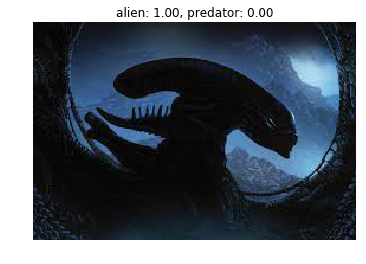

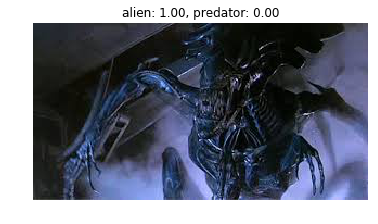

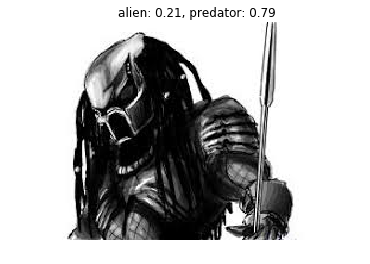

In [18]:
for i, img in enumerate(img_list):
    plt.figure()
    plt.axis('off')
    plt.title("alien: {:.2f}, predator: {:.2f}".format(pred_probs[i,0], 
                                                       pred_probs[i,1]))
    plt.imshow(img)